In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import time

In [77]:
# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [78]:
train_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
val_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.2),  # Dropout 20%
    nn.Linear(model.last_channel, 2)
)
model = model.to(device)

In [79]:
# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [80]:
# Training Setup
num_epochs = 15
patience = 5  # Early Stopping jika tidak ada peningkatan selama 5 epoch
best_val_loss = np.inf  # Simpan loss terbaik
early_stop_counter = 0  # Counter untuk Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [81]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === VALIDATION PHASE ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === Classification Report ===
    # class_report = classification_report(all_labels, all_preds, target_names=["Not Worn", "Worn"])
    
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.2f}%")
    # print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")
    # print("Classification Report:\n", class_report)

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter jika ada peningkatan
        torch.save(model.state_dict(), "CustomMobileNetv2.h5")  # Simpan model terbaik
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early Stopping diterapkan setelah {epoch+1} epoch.")
        break  # Hentikan training

print("Model selesai dilatih dan disimpan.")

Epoch [1/15] | Train Loss: 0.5264, Train Acc: 71.95% | Val Loss: 0.3563, Val Acc: 81.79%
Epoch [2/15] | Train Loss: 0.2871, Train Acc: 86.83% | Val Loss: 0.2224, Val Acc: 90.71%
Epoch [3/15] | Train Loss: 0.1665, Train Acc: 93.28% | Val Loss: 0.1570, Val Acc: 93.57%
Epoch [4/15] | Train Loss: 0.1383, Train Acc: 94.09% | Val Loss: 0.1310, Val Acc: 94.29%
Epoch [5/15] | Train Loss: 0.1031, Train Acc: 95.97% | Val Loss: 0.1294, Val Acc: 94.29%
Epoch [6/15] | Train Loss: 0.0701, Train Acc: 97.40% | Val Loss: 0.1220, Val Acc: 95.00%
Epoch [7/15] | Train Loss: 0.0712, Train Acc: 97.67% | Val Loss: 0.1003, Val Acc: 95.36%
Epoch [8/15] | Train Loss: 0.0669, Train Acc: 97.31% | Val Loss: 0.1402, Val Acc: 95.36%
Epoch [9/15] | Train Loss: 0.0521, Train Acc: 97.94% | Val Loss: 0.1280, Val Acc: 96.07%
Epoch [10/15] | Train Loss: 0.0434, Train Acc: 98.75% | Val Loss: 0.1318, Val Acc: 96.07%
Epoch [11/15] | Train Loss: 0.0506, Train Acc: 97.94% | Val Loss: 0.1390, Val Acc: 95.00%
Epoch [12/15] | Tra

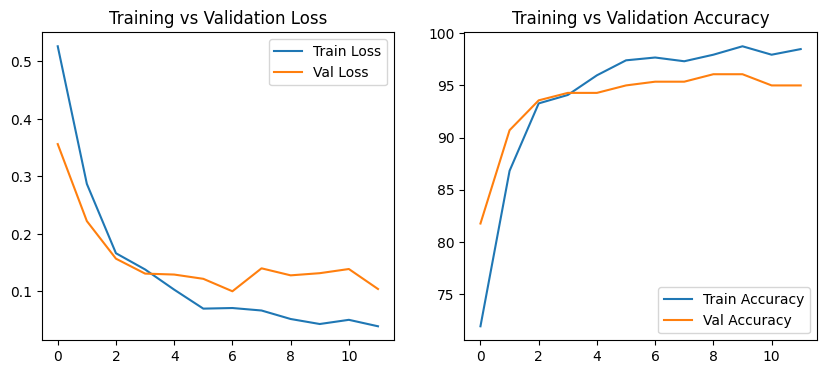

In [84]:
import matplotlib.pyplot as plt

# === PLOT TRAINING & VALIDATION CURVES ===
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()

In [83]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Training Model ShuffleNetV2

In [105]:
# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [106]:
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights

train_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
val_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
model = models.shufflenet_v2_x0_5(weights=weights)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),  # Dropout 20%
    nn.Linear(in_features, 2)
)
model = model.to(device)

In [107]:
# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [108]:
# Training Setup
num_epochs = 20
patience = 5  # Early Stopping jika tidak ada peningkatan selama 5 epoch
best_val_loss = np.inf  # Simpan loss terbaik
early_stop_counter = 0  # Counter untuk Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [109]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === VALIDATION PHASE ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === Classification Report ===
    # class_report = classification_report(all_labels, all_preds, target_names=["Not Worn", "Worn"])
    
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.2f}%")
    # print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")
    # print("Classification Report:\n", class_report)

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter jika ada peningkatan
        torch.save(model.state_dict(), "CustomShuffleNetV2.h5")  # Simpan model terbaik
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early Stopping diterapkan setelah {epoch+1} epoch.")
        break  # Hentikan training

print("Model selesai dilatih dan disimpan.")

Epoch [1/20] | Train Loss: 0.6887, Train Acc: 53.58% | Val Loss: 0.6835, Val Acc: 58.93%
Epoch [2/20] | Train Loss: 0.6773, Train Acc: 66.13% | Val Loss: 0.6685, Val Acc: 67.86%
Epoch [3/20] | Train Loss: 0.6558, Train Acc: 71.95% | Val Loss: 0.6376, Val Acc: 76.79%
Epoch [4/20] | Train Loss: 0.6071, Train Acc: 78.49% | Val Loss: 0.5779, Val Acc: 80.36%
Epoch [5/20] | Train Loss: 0.5435, Train Acc: 82.71% | Val Loss: 0.4998, Val Acc: 83.57%
Epoch [6/20] | Train Loss: 0.4616, Train Acc: 85.13% | Val Loss: 0.4133, Val Acc: 87.14%
Epoch [7/20] | Train Loss: 0.3890, Train Acc: 87.63% | Val Loss: 0.3560, Val Acc: 86.79%
Epoch [8/20] | Train Loss: 0.3285, Train Acc: 88.98% | Val Loss: 0.2917, Val Acc: 90.00%
Epoch [9/20] | Train Loss: 0.2896, Train Acc: 90.59% | Val Loss: 0.2800, Val Acc: 90.36%
Epoch [10/20] | Train Loss: 0.2484, Train Acc: 91.22% | Val Loss: 0.2534, Val Acc: 91.79%
Epoch [11/20] | Train Loss: 0.2194, Train Acc: 92.83% | Val Loss: 0.2225, Val Acc: 92.86%
Epoch [12/20] | Tra

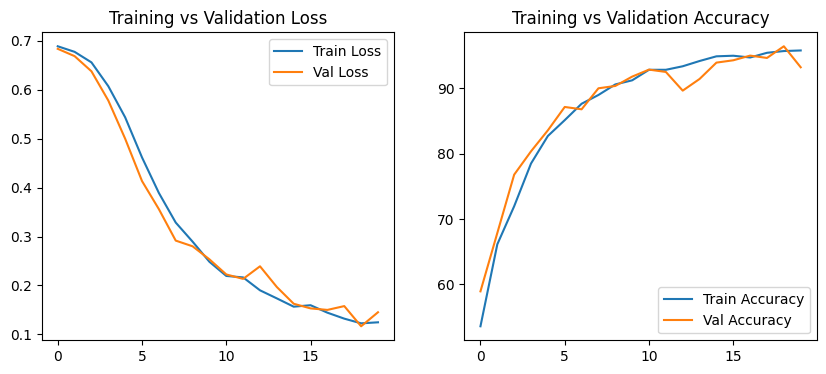

In [111]:
import matplotlib.pyplot as plt

# === PLOT TRAINING & VALIDATION CURVES ===
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()

In [ ]:
# Training Model SqueezNet

In [117]:
# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [118]:
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights

train_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
val_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = SqueezeNet1_1_Weights.IMAGENET1K_V1
model = models.squeezenet1_1(weights=weights)

# Modify Classifier Layer
in_features = model.classifier[1].in_channels
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(in_features, 2, kernel_size=1),
    nn.AdaptiveAvgPool2d((1, 1))
)

model = model.to(device)

In [119]:
# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [120]:
# Training Setup
num_epochs = 20
patience = 5  # Early Stopping jika tidak ada peningkatan selama 5 epoch
best_val_loss = np.inf  # Simpan loss terbaik
early_stop_counter = 0  # Counter untuk Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [121]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === VALIDATION PHASE ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === Classification Report ===
    # class_report = classification_report(all_labels, all_preds, target_names=["Not Worn", "Worn"])
    
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.2f}%")
    # print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")
    # print("Classification Report:\n", class_report)

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter jika ada peningkatan
        torch.save(model.state_dict(), "CustomSqueezNet1_1.h5")  # Simpan model terbaik
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early Stopping diterapkan setelah {epoch+1} epoch.")
        break  # Hentikan training

print("Model selesai dilatih dan disimpan.")

Epoch [1/20] | Train Loss: 0.6892, Train Acc: 56.18% | Val Loss: 0.6797, Val Acc: 62.14%
Epoch [2/20] | Train Loss: 0.6510, Train Acc: 66.94% | Val Loss: 0.6030, Val Acc: 74.29%
Epoch [3/20] | Train Loss: 0.6150, Train Acc: 69.09% | Val Loss: 0.6761, Val Acc: 50.71%
Epoch [4/20] | Train Loss: 0.6516, Train Acc: 56.81% | Val Loss: 0.5008, Val Acc: 76.43%
Epoch [5/20] | Train Loss: 0.4465, Train Acc: 78.14% | Val Loss: 0.3378, Val Acc: 83.21%
Epoch [6/20] | Train Loss: 0.4089, Train Acc: 81.18% | Val Loss: 0.3002, Val Acc: 87.86%
Epoch [7/20] | Train Loss: 0.2718, Train Acc: 88.26% | Val Loss: 0.2629, Val Acc: 89.64%
Epoch [8/20] | Train Loss: 0.2830, Train Acc: 87.01% | Val Loss: 0.2679, Val Acc: 87.50%
Epoch [9/20] | Train Loss: 0.2668, Train Acc: 88.80% | Val Loss: 0.2645, Val Acc: 89.29%
Epoch [10/20] | Train Loss: 0.2027, Train Acc: 91.13% | Val Loss: 0.1918, Val Acc: 91.43%
Epoch [11/20] | Train Loss: 0.1879, Train Acc: 92.38% | Val Loss: 0.1739, Val Acc: 92.86%
Epoch [12/20] | Tra

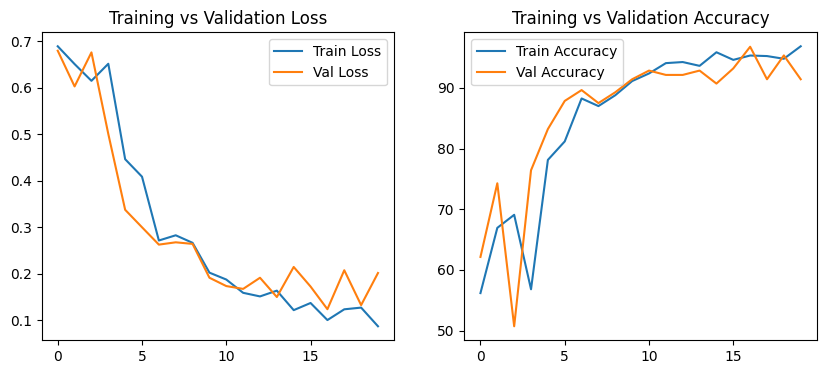

In [122]:
import matplotlib.pyplot as plt

# === PLOT TRAINING & VALIDATION CURVES ===
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()

In [ ]:
# Train Model EfficientNet

In [3]:
# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

train_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
val_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

# Modify Classifier Layer
in_features = model.classifier[1].in_features  
model.classifier[1] = nn.Linear(in_features, 2) 

model = model.to(device)

In [6]:
# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [7]:
# Training Setup
num_epochs = 20
patience = 5  # Early Stopping jika tidak ada peningkatan selama 5 epoch
best_val_loss = np.inf  # Simpan loss terbaik
early_stop_counter = 0  # Counter untuk Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === VALIDATION PHASE ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === Classification Report ===
    # class_report = classification_report(all_labels, all_preds, target_names=["Not Worn", "Worn"])
    
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.2f}%")
    # print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")
    # print("Classification Report:\n", class_report)

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter jika ada peningkatan
        torch.save(model.state_dict(), "CustomEfficientNet1_1.h5")  # Simpan model terbaik
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early Stopping diterapkan setelah {epoch+1} epoch.")
        break  # Hentikan training

print("Model selesai dilatih dan disimpan.")

Epoch [1/20] | Train Loss: 0.6123, Train Acc: 68.01% | Val Loss: 0.4975, Val Acc: 77.86%
Epoch [2/20] | Train Loss: 0.3867, Train Acc: 86.11% | Val Loss: 0.2603, Val Acc: 92.14%
Epoch [3/20] | Train Loss: 0.2264, Train Acc: 92.11% | Val Loss: 0.2019, Val Acc: 90.71%
Epoch [4/20] | Train Loss: 0.1391, Train Acc: 95.07% | Val Loss: 0.1542, Val Acc: 93.57%
Epoch [5/20] | Train Loss: 0.1141, Train Acc: 96.42% | Val Loss: 0.1439, Val Acc: 93.93%
Epoch [6/20] | Train Loss: 0.0925, Train Acc: 97.04% | Val Loss: 0.1509, Val Acc: 94.29%
Epoch [7/20] | Train Loss: 0.0879, Train Acc: 96.51% | Val Loss: 0.0916, Val Acc: 97.14%
Epoch [8/20] | Train Loss: 0.0508, Train Acc: 98.12% | Val Loss: 0.0931, Val Acc: 96.79%
Epoch [9/20] | Train Loss: 0.0893, Train Acc: 96.77% | Val Loss: 0.0946, Val Acc: 96.07%
Epoch [10/20] | Train Loss: 0.0393, Train Acc: 98.92% | Val Loss: 0.0983, Val Acc: 95.71%
Epoch [11/20] | Train Loss: 0.0349, Train Acc: 98.84% | Val Loss: 0.1357, Val Acc: 95.00%
Epoch [12/20] | Tra

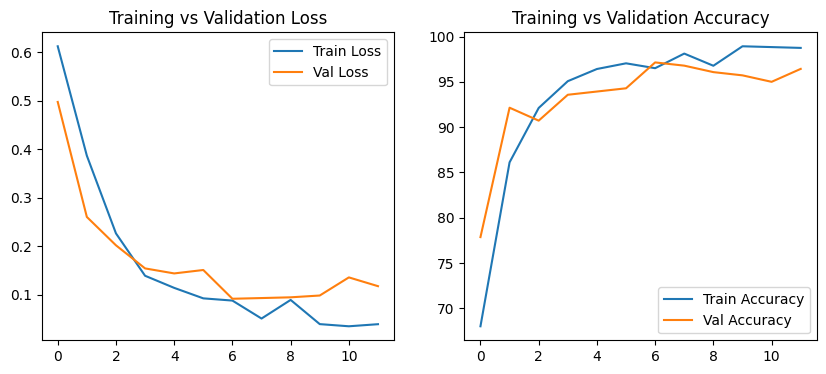

In [9]:
import matplotlib.pyplot as plt

# === PLOT TRAINING & VALIDATION CURVES ===
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()

In [ ]:
# Train Model Resnet

In [10]:
# Dataset Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
from torchvision.models import resnet18, ResNet18_Weights

train_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
val_dataset = ImageFolder(root="D:\\TA_Lalu Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

# Modify Classifier Layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)  # Output 2 kelas

model = model.to(device)

In [14]:
# Optimizer & Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [15]:
# Training Setup
num_epochs = 20
patience = 5  # Early Stopping jika tidak ada peningkatan selama 5 epoch
best_val_loss = np.inf  # Simpan loss terbaik
early_stop_counter = 0  # Counter untuk Early Stopping
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === VALIDATION PHASE ===
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === Classification Report ===
    # class_report = classification_report(all_labels, all_preds, target_names=["Not Worn", "Worn"])
    
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.2f}%")
    # print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")
    # print("Classification Report:\n", class_report)

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter jika ada peningkatan
        torch.save(model.state_dict(), "CustomResnet18.h5")  # Simpan model terbaik
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early Stopping diterapkan setelah {epoch+1} epoch.")
        break  # Hentikan training

print("Model selesai dilatih dan disimpan.")

Epoch [1/20] | Train Loss: 0.4451, Train Acc: 78.32% | Val Loss: 0.2911, Val Acc: 86.79%
Epoch [2/20] | Train Loss: 0.1837, Train Acc: 92.83% | Val Loss: 0.1714, Val Acc: 93.93%
Epoch [3/20] | Train Loss: 0.1167, Train Acc: 95.43% | Val Loss: 0.1413, Val Acc: 93.21%
Epoch [4/20] | Train Loss: 0.0739, Train Acc: 97.22% | Val Loss: 0.1040, Val Acc: 95.71%
Epoch [5/20] | Train Loss: 0.0715, Train Acc: 97.67% | Val Loss: 0.1454, Val Acc: 95.00%
Epoch [6/20] | Train Loss: 0.0784, Train Acc: 97.40% | Val Loss: 0.2129, Val Acc: 92.86%
Epoch [7/20] | Train Loss: 0.0483, Train Acc: 98.75% | Val Loss: 0.0900, Val Acc: 97.14%
Epoch [8/20] | Train Loss: 0.0393, Train Acc: 98.66% | Val Loss: 0.1908, Val Acc: 92.14%
Epoch [9/20] | Train Loss: 0.0457, Train Acc: 98.84% | Val Loss: 0.1141, Val Acc: 95.36%
Epoch [10/20] | Train Loss: 0.0282, Train Acc: 99.37% | Val Loss: 0.1319, Val Acc: 93.57%
Epoch [11/20] | Train Loss: 0.0405, Train Acc: 98.57% | Val Loss: 0.1498, Val Acc: 93.93%
Epoch [12/20] | Tra

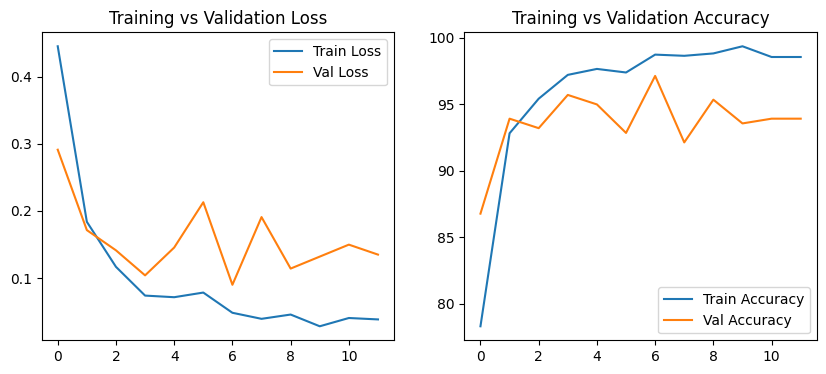

In [17]:
import matplotlib.pyplot as plt

# === PLOT TRAINING & VALIDATION CURVES ===
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()